# Import packages

In [65]:
import os
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load data

In [66]:
nlp = spacy.load("en_core_web_sm")

In [67]:
# Load the environment variables
load_dotenv()

# Get the paths to the data
data_dir = os.getenv("DATA_DIR")
articles_dir = os.path.join(data_dir, "articles")

# Load the main dataset
df = pd.read_csv(f"{data_dir}/article_info_V2.csv", index_col=0, parse_dates=[1])

# Load the external dataset
external_df = pd.read_csv(f"{data_dir}/other-articles.csv", index_col=0, parse_dates=[1], sep=";")

# Cleaning

In [68]:
# Drop unused columns
df.drop(columns=["Author", "Type", "Keywords"], inplace=True)

# Drop rows with empty date values
df.dropna(subset=["Date"], inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Remove the url column from the external dataset
external_df.drop(columns=["Url"], inplace=True)

# Merging datasets

In [69]:
# Add the external dataset to the main dataset
df = pd.concat([df, external_df])

# Reset the index
df.reset_index(drop=True, inplace=True)

# Clear the external dataset variable
del external_df

# Remove duplicates

In [70]:
# Count the number of entries before duplicate removal
entries_count = len(df)

# remove duplicate entries by title and date
df.drop_duplicates(subset=["Title", "Date"], keep="first", inplace=True)

# Print the number of deleted entries
print(f"Removed {entries_count - len(df)} duplicate entries.")

# Clear the entries count variable
del entries_count

Removed 3 duplicate entries.


# Parse target

In [71]:
# Define functions to parse target
def clean_string(str):
    # Make the string lowercase
    str = str.lower()
    # Remove all non-alphanumeric characters
    str = re.sub(r"[^\w\s]", "", str)
    # Remove the leading and trailing spaces
    return str.strip()

def parse_tags(str):
    # Split the string on each comma
    raw_list = str.split(",")
    # Clean every string in the list
    return list(map(clean_string, raw_list))

In [72]:
# Convert the raw string values of the Tags column to lists of strings
df["Tags"] = df["Tags"].apply(parse_tags)

In [73]:
# Clear the cleaning and parsing functions
del clean_string, parse_tags

# Load articles

In [74]:
# Article loading function
def load_article(title):
    # Create filename from title
    file_name = f"{title}.txt"
    # Get the path of the article
    file_path = os.path.join(articles_dir, file_name)
    try:
        # Attempt to read the article
        file = open(file_path, "r", encoding="utf-8")
    except:
        # If the article could not be read, return None
        return None
    # Read the contents of the article
    contents = file.read()
    # Close the file
    file.close()
    # Return the contents of the article
    return contents

In [75]:
# Load the articles
df["Contents"] = df["Title"].apply(load_article)

# Clear the article loading function
del load_article

In [76]:
# Count the number of entries in the dataframe
entries_count = len(df)

# Remove rows without article contents
df.dropna(subset=["Contents"], inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Print the number of deleted entries
print(f"Removed {entries_count - len(df)} entries without article contents.")

# Clear the entries count variable
del entries_count

Removed 42 entries without article contents.


# Create categories from tags

In [77]:
unique_tags = []
for tag_list in df["Tags"]:
    for tag in tag_list:
        if tag not in unique_tags:
            unique_tags.append(tag)

In [78]:
# Load the custom categories dataset
custom_categories = pd.read_csv(f"{data_dir}/custom-categories.csv", sep=";")

# After receiving feedback from SKC, we decided to drop the following categories:
custom_categories.drop(columns=["People", "Places", "Criminal groups"], inplace=True)

# Define a function to parse the custom categories into a list of strings
def load_category(name):
    try:
        return custom_categories[name].dropna().tolist()
    except:
        return None

In [79]:
# Initiate the category dictionary
categories = {}

# Iterate over these custom_categories columns
for category_name in custom_categories.columns:
    # Load the category
    categories[category_name] = load_category(category_name)

In [80]:
# Create a new column for the category
df["Category"] = ""

# Iterate over the dataframe
for index, row in df.iterrows():
    # Get the tags of the current row
    tag_list = row["Tags"]
    # Create a dictionary for the counters of the categories for this article
    counters = {}
    # Iterate over every tag in the tag list
    for tag in tag_list:
        # Iterate over the categories
        for category_name in categories:
            # Get the current category
            category = categories[category_name]
            # Check if the tag is in the category list
            if tag in category:
                # If it is, add it to the counters dictionary
                if category_name not in counters:
                    counters[category_name] = 1
                else:
                    counters[category_name] += 1    
    # Get the category with the highest counter and assign it to the row
    if len(counters) == 0:
        row["Category"] = "Other"
    else:
        row["Category"] = max(counters, key=counters.get)

In [81]:
categories = df["Category"].value_counts()

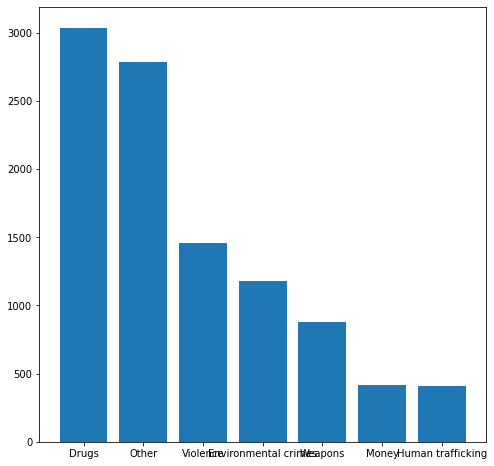

In [82]:
plt.figure(figsize=(12, 8))
plt.bar(categories.index, categories.values)
plt.show()

In [83]:
# # remove location, environmental, violence, weapons, money, human trafficking and drugs tags from the list of unique tags
# remaining_tags = [tag for tag in unique_tags if tag not in environmental_tags and tag not in violence_tags and tag not in weapons_tags and tag not in money_tags and tag not in human_trafficking_tags and tag not in drugs_tags]
# remaining_tags

# print(f"{len(remaining_tags)} / {len(unique_tags)} unique tags have not been categorized yet.")

# print(remaining_tags)